# Meshing ETOPO1

In this notebook we:

1. Find the land surface in a region by filtering ETOPO1 
2. Create a DM object for all the data points
3. Save the mesh to HDF5 file

In [2]:
from osgeo import gdal

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

import quagmire

from scipy.ndimage.filters import gaussian_filter

In [8]:
## Define region of interest (here NZ) 

japan_bounds = (129.0, 30.0, 148.0, 47.0)
australia_bounds = (110, -45, 160, -10)
tasmania_bounds = (144, -44, 149, -40)
new_zealand_bounds = (166, -47.5, 179, -34)

In [9]:
## Read ETOPO1 data from online service

import xarray

(left, bottom, right, top) = new_zealand_bounds
map_extent = ( left, right, bottom, top)

etopo_dataset = "http://thredds.socib.es/thredds/dodsC/ancillary_data/bathymetry/ETOPO1_Bed_g_gmt4.nc"
etopo_data = xarray.open_dataset(etopo_dataset)
regional_data = etopo_data.sel(x=slice(left,right), y=slice(bottom, top))


lons = regional_data.coords.get('x')
lats = regional_data.coords.get('y')
vals = regional_data['z']

x,y = np.meshgrid(lons.data, lats.data)
height = vals.data

In [10]:
## Here is how to clip the original tif and save a new file

# opts = gdal.WarpOptions(outputBounds=japan_bounds)
# gdalobj = gdal.Warp(destNameOrDestDS="JapanEtopo1.tif", srcDSOrSrcDSTab="../../../ETOPO1/ETOPO1_Ice_c_geotiff.tif", options=opts )
# print("Japan - ", gdalobj.RasterXSize, gdalobj.RasterYSize)
# gdalobj = None  # this closes the file and saves the data

# opts = gdal.WarpOptions(outputBounds=australia_bounds)
# gdalobj = gdal.Warp(destNameOrDestDS="AustraliaEtopo1.tif", srcDSOrSrcDSTab="../../../ETOPO1/ETOPO1_Ice_c_geotiff.tif", options=opts )
# print("Australia - ", gdalobj.RasterXSize, gdalobj.RasterYSize)
# gdalobj = None  # this closes the file and saves the data

# opts = gdal.WarpOptions(outputBounds=tasmania_bounds)
# gdalobj = gdal.Warp(destNameOrDestDS="TasmaniaEtopo1.tif", srcDSOrSrcDSTab="../../../ETOPO1/ETOPO1_Ice_c_geotiff.tif", options=opts )
# print("Tasmania - ", gdalobj.RasterXSize, gdalobj.RasterYSize)
# gdalobj = None  # this closes the file and saves the data

# opts = gdal.WarpOptions(outputBounds=new_zealand_bounds)
# gdalobj = gdal.Warp(destNameOrDestDS="NZEtopo1.tif", srcDSOrSrcDSTab="../../../ETOPO1/ETOPO1_Ice_c_geotiff.tif", options=opts )
# print("NZ - ", gdalobj.RasterXSize, gdalobj.RasterYSize)
# gdalobj = None  # this closes the file and saves the data

In [11]:
# file = "NZEtopo1.tif"

# ds = gdal.Open(file)
# band = ds.GetRasterBand(1)
# height = band.ReadAsArray()
# [cols, rows] = height.shape

# left, hres, n0, top, n1, vres = ds.GetGeoTransform()
# right = left+rows*hres
# bottom = top+cols*vres
# x,y = np.meshgrid(np.arange(left, right, hres), np.arange(top,  bottom, vres))

# map_extent = ( left, right, bottom, top)

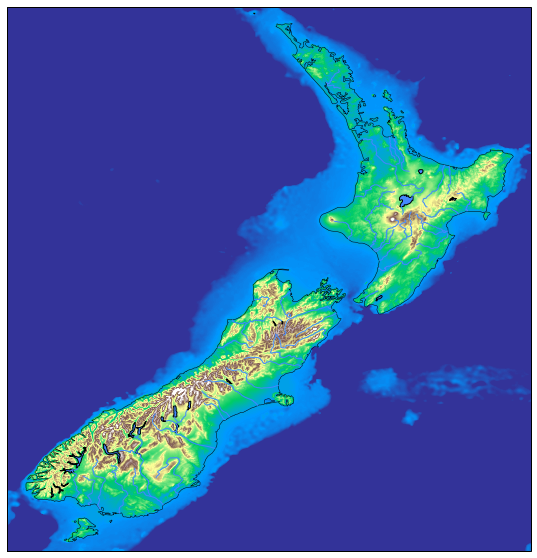

In [12]:
## Plot the heights as a contour map


import cartopy.crs as ccrs
import cartopy.feature as cfeature

coastline = cfeature.NaturalEarthFeature('physical', 'coastline', '10m',
                           edgecolor=(1.0,0.8,0.0),
                           facecolor="none")

ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '10m',
                           edgecolor="green",
                           facecolor="blue")

lakes = cfeature.NaturalEarthFeature('physical', 'lakes', '10m',
                           edgecolor="green",
                           facecolor="#4488FF")

rivers = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '10m',
                           edgecolor="#4488FF",
                           facecolor="blue")

plt.figure(figsize=(15, 10))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.set_extent(map_extent)

ax.add_feature(coastline, edgecolor="black", linewidth=0.5, zorder=3)
ax.add_feature(lakes,     edgecolor="black", linewidth=1, zorder=3)
ax.add_feature(rivers   , facecolor="none", linewidth=1, zorder=3)

plt.imshow(height, extent=map_extent, transform=ccrs.PlateCarree(),
           cmap='terrain', origin='lower', vmin=-400., vmax=2000.)

In [13]:
## Filter out the points we don't want at all 

points = height > -100

m1s = height[points]
x1s = x[points]
y1s = y[points]

submarine = m1s < 0.0
subaerial = m1s >= 0.0

/Users/lmoresi/opt/anaconda3/envs/quagmire_gdal/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


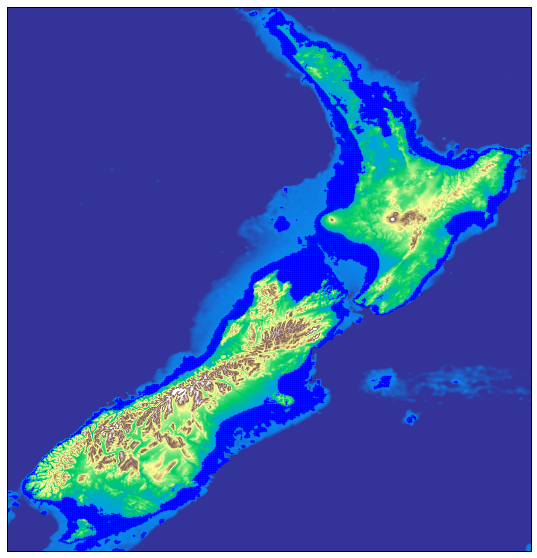

In [14]:
fig = plt.figure(figsize=(15, 10))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.set_extent(map_extent)

plt.imshow(height, extent=map_extent, transform=ccrs.PlateCarree(),
           cmap='terrain', origin='lower', vmin=-400., vmax=2000.)

ax.scatter(x1s[submarine], y1s[submarine],  s=0.1, color="Blue", transform=ccrs.Geodetic())
#ax.scatter(x1s[subaerial], y1s[subaerial], s=0.1, color="Red", transform=ccrs.Geodetic())


fig.show()

In [15]:
## triangulate

import stripy
mesh0 = stripy.cartesian.Triangulation(x1s, y1s, permute=True, tree=True)

d, n = mesh0.nearest_vertices(mesh0.points[submarine][:,0], mesh0.points[submarine][:,1], k=25)

candidates = np.where(np.any(subaerial[n],axis=1))
keepers = n[candidates,0]

boundary = np.zeros_like(subaerial)
boundary[keepers] = True

/Users/lmoresi/opt/anaconda3/envs/quagmire_gdal/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


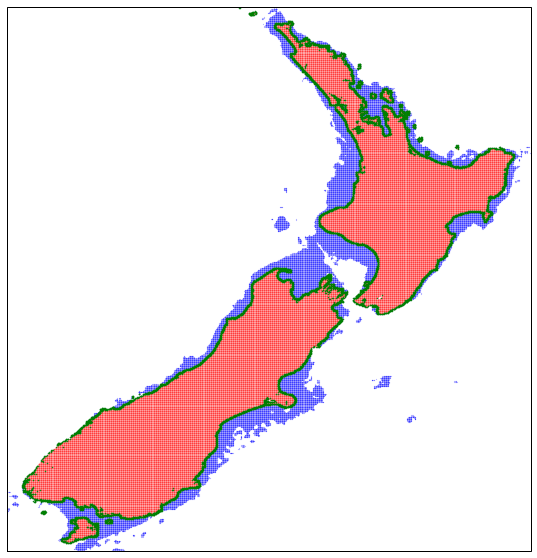

In [16]:
fig = plt.figure(figsize=(15, 10))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.set_extent(map_extent)

ax.scatter(x1s[submarine], y1s[submarine], s=0.01, color="Blue", transform=ccrs.Geodetic() )
ax.scatter(x1s[subaerial], y1s[subaerial], s=0.01, color="Red",  transform=ccrs.Geodetic() )
ax.scatter(x1s[boundary],  y1s[boundary],  s=0.25, color="Green",transform=ccrs.Geodetic() )

fig.show()

In [17]:
## Now re-define the various arrays on this subset of the data

points2 = np.zeros_like(points)
points2[points] = subaerial | boundary

m2s = height[points2]
x2s = x[points2]
y2s = y[points2]
bmask2 = subaerial[subaerial | boundary] 

/Users/lmoresi/opt/anaconda3/envs/quagmire_gdal/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


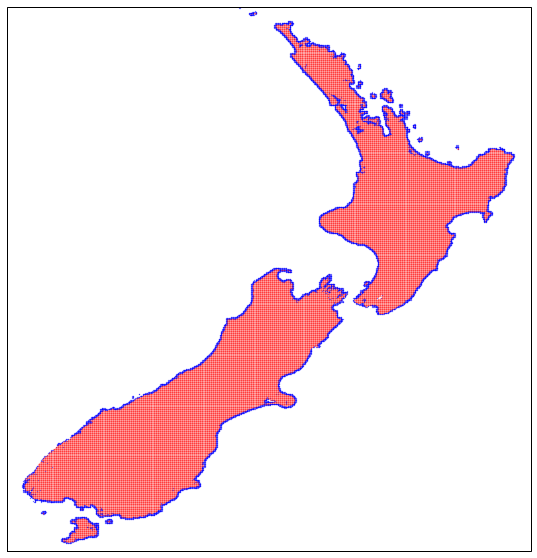

In [18]:
fig = plt.figure(figsize=(15, 10))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.set_extent(map_extent)

ax.scatter(x2s[~bmask2],  y2s[~bmask2], s=0.05, color="blue", transform=ccrs.Geodetic())
ax.scatter(x2s[ bmask2],  y2s[ bmask2], s=0.01, color="Red", transform=ccrs.Geodetic())

fig.show()

### 3. Create the DM

The points are now read into a DM

In [19]:
DM = meshtools.create_DMPlex_from_points(x2s, y2s, bmask2, refinement_levels=0)

In [20]:
mesh = quagmire.SurfaceProcessMesh(DM, verbose=True, permute=True, downhill_neighbours=2)

0 - Delaunay triangulation 0.4568526529999417s
0 - Calculate node weights and area 0.45897153399994295s
0 - Find boundaries 0.012496648000023924s
0 - cKDTree 0.0268411219999507s
0 - Construct neighbour cloud array 0.6164722450000681s
0 - Construct rbf weights 0.14250376999996206s


In [21]:
x2r = mesh.tri.x
y2r = mesh.tri.y
simplices = mesh.tri.simplices
bmaskr = mesh.bmask

In [22]:
with mesh.deform_topography():
    mesh.topography.data = m2s                       

0 - Build downhill matrices 0.408297765000043s
0 - Build upstream areas 0.16809809099993345s


In [23]:
low_points1 = mesh.identify_low_points()
low_point_coords1 = mesh.coords[low_points1] 
print(low_points1.shape)

cumulative_flow_1 = mesh.upstream_integral_fn(mesh.topography**2).evaluate(mesh)
topography_1 = mesh.topography.data[:]

(1424,)


In [24]:
logflow = np.log10(1.0e-3+cumulative_flow_1)
logflow.min(), logflow.max()

(-3.0, 5.457895777215018)

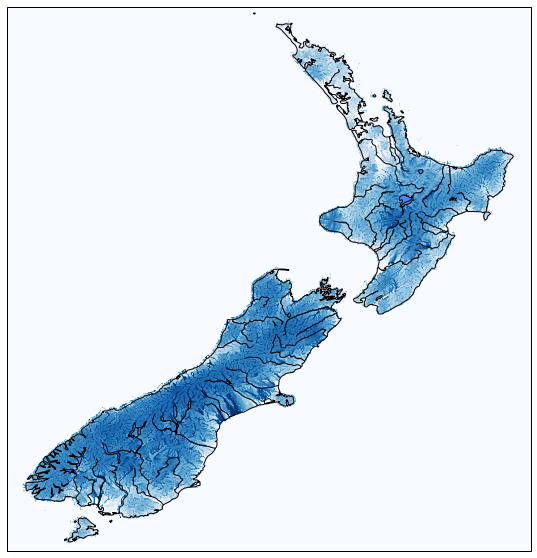

In [26]:
logflow = np.log10(1.0e-3+cumulative_flow_1)
flows_img1 = logflow.min() * np.ones_like(points2)
flows_img1[points2] = logflow

plt.figure(figsize=(15, 10))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.set_extent(map_extent)

ax.add_feature(coastline, edgecolor="black", linewidth=1, zorder=3)
ax.add_feature(lakes,     edgecolor="black", linewidth=1, zorder=3)
ax.add_feature(rivers   , edgecolor="black", facecolor="none", linewidth=1, zorder=3)

# ax.scatter(x2s[~bmask2], y2s[~bmask2], color="#660000", s=.1)

plt.imshow(flows_img1, extent=map_extent, transform=ccrs.PlateCarree(),
           cmap='Blues', origin='lower', vmin=0.0, vmax=4.0)

plt.savefig("Flowpath-Wex1-1.png", dpi=250)

## Low-point -filling algorithm

Most effective seems to be a little local patching followed by some iterations of the swamp fill. Repeat as necessary and check periodically to see what is actually happening.

In [27]:
for repeat in range(0,2):

    mesh.low_points_local_patch_fill(its=3, smoothing_steps=2)
    topography_2 = mesh.topography.data[:]
    cumulative_flow_2 = mesh.upstream_integral_fn(mesh.topography**2).evaluate(mesh)

    low_points2 = mesh.identify_low_points()
    low_point_coords2 = mesh.coords[low_points2] 
    print("Low points - {}".format(low_points2.shape))

    for i in range(0,10):
        mesh.low_points_swamp_fill(ref_height=0.0, saddles=True)

        # In parallel, we can't break if ANY processor has work to do (barrier / sync issue)
        low_points3 = mesh.identify_global_low_points()

        print("{} : {}".format(i,low_points3[0]))
        if low_points3[0] == 0:
            break



Low point local patch fill
0 - Build downhill matrices 0.39418156099998214s
0 - Build downhill matrices 0.36973827999997866s
0 - Build downhill matrices 0.3612931569999773s
Low point local patch fill  1.32038155500004  seconds
0 - Build upstream areas 0.1910934370000632s
Low points - (398,)
76  iterations, time =  0.1312829610000108
Build low point catchments -  0.13202341800001705  seconds
0  Sort spills -  0.013581433000013021
0  Gather spill data -  0.010894073000031312
0  Sort all spills -  0.00025047500002983725
0 - Build downhill matrices 0.4359843469999305s
Low point swamp fill  0.6911864180000293  seconds
0 - Build upstream areas 0.20046297299995786s
0 : 519
76  iterations, time =  0.14301716600004966
Build low point catchments -  0.14353476999997383  seconds
0  Sort spills -  0.017221931999984008
0  Gather spill data -  9.975699992992304e-05
0  Sort all spills -  0.00015412000004744186
0 - Build downhill matrices 0.3662884509999458s
Low point swamp fill  0.6258802329999753  se

In [28]:
cumulative_flow_3 = mesh.upstream_integral_fn(mesh.topography**2).evaluate(mesh)
topography_3 = mesh.topography.data[:]
low_points3 = mesh.identify_low_points()
print("Low points - {}".format(low_points3.shape))

Low points - (12,)


In [29]:
hdiff = height.copy()
hdiff[points2]  =  mesh.topography.data - height[points2]
hdiff[~points2] = 0.0

In [30]:
outflows = mesh.identify_outflow_points()

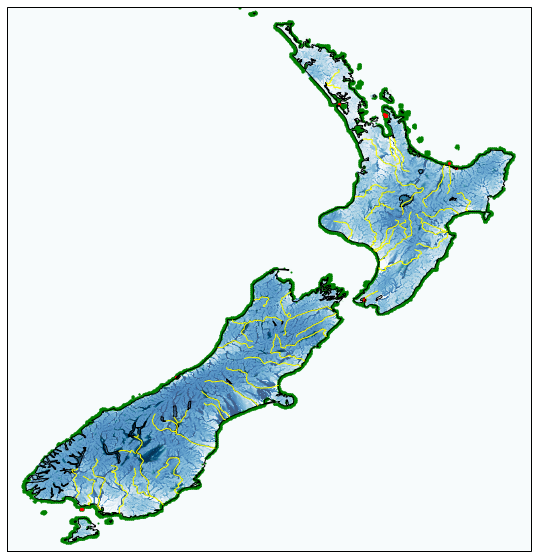

In [33]:
logflow = np.log10(1.0e-3+cumulative_flow_3)
flows_img3 = logflow.min() * np.ones_like(points2)
flows_img3[points2] = logflow


plt.figure(figsize=(15, 10))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.set_extent(map_extent)

ax.add_feature(coastline, edgecolor="black", linewidth=1, zorder=3)
ax.add_feature(lakes,     edgecolor="black", facecolor="none", linewidth=1, zorder=3)
ax.add_feature(rivers   , edgecolor="Yellow", facecolor="none", linewidth=1, zorder=3)

plt.imshow(flows_img3, extent=map_extent, transform=ccrs.PlateCarree(),
           cmap='Blues', origin='lower', vmin=0.0, vmax=4.0)

ax.scatter(x2s[outflows], y2s[outflows], color="Green", s=1.0)
ax.scatter(x2s[low_points3], y2s[low_points3], color="Red", s=5.0)

plt.imshow(hdiff, extent=map_extent, transform=ccrs.PlateCarree(),
           cmap='Greens', origin='lower', vmin=0.0, vmax=200, alpha=0.25)

plt.savefig("WEx1-Flowpath-3.png", dpi=250)

In [35]:
# ## We can also dump the modified topography to a geotiff matching the original

# ## NOTE the vertical resolution of the ETOPO geotiff is 1m (int16) - not enough to
# ## record the changes necessary for the hydrological flow connections.

# hnew = np.zeros_like(height, dtype=float)
# hnew[points2]  = mesh.topography.data
# hnew[~points2] = height[~points2]

# arr_out = hnew
# ds = gdal.Open(file)
# driver = gdal.GetDriverByName("GTiff")
# outdata = driver.Create("WEx1-ETOPO1-quagmire.tif", rows, cols, 1, gdal.GDT_Float32)
# outdata.SetGeoTransform(ds.GetGeoTransform())      ##sets same geotransform as input
# outdata.SetProjection(ds.GetProjection())          ##sets same projection as input
# outdata.GetRasterBand(1).WriteArray(arr_out)
# outdata.FlushCache() ##saves to disk!!
# outdata = None
# band=None
# ds=None

In [36]:
## verify

ds = gdal.Open("WEx1-ETOPO1-quagmire.tif")
band = ds.GetRasterBand(1)
height = band.ReadAsArray()
[cols, rows] = height.shape

left, hres, n0, top, n1, vres = ds.GetGeoTransform()
right = left+rows*hres
bottom = top+cols*vres
x,y = np.meshgrid(np.arange(left, right, hres), np.arange(top,  bottom, vres))

map_extent = ( left, right, bottom, top)

point_mask = height > -10.0

xs = x[point_mask]
ys = y[point_mask]
heights = height[point_mask]
points = np.column_stack([xs, ys])

submarine = (heights <  0.0 )
subaerial = (heights >= 0.0 )

DM1 = meshtools.create_DMPlex_from_points(xs, ys, bmask=subaerial, refinement_levels=0)
mesh1 = quagmire.SurfaceProcessMesh(DM1, verbose=True, permute=False, downhill_neighbours=2)
with mesh1.deform_topography():
    mesh1.topography.data = heights
    
mesh1.identify_low_points().shape

AttributeError: 'NoneType' object has no attribute 'GetRasterBand'

In [27]:
99 = 1

## The hdf5 functionality may not work for conda installations due to limitations in the available petsc builds.

SyntaxError: can't assign to literal (<ipython-input-27-9cb830716c35>, line 1)

## 5. Save to HDF5

Save the mesh to an HDF5 file so that it can be visualised in Paraview or read into Quagmire another time. There are two ways to do this:

1. Using the `save_DM_to_hdf5` function in meshtools, or
2. Directly from trimesh interface using `save_mesh_to_hdf5` method.

Remember to execute `petsc_gen_xdmf.py austopo.h5` to create the XML file structure necessary to visualise the mesh in paraview.

In [ ]:
filename = 'NZTopo.h5'

mesh.save_mesh_to_hdf5(filename)
mesh.save_field_to_hdf5(filename, height=mesh.height, 
                                  height0=raw_heights,
                                  slope=mesh.slope, 
                                  flow1=np.sqrt(flowpaths1),
                                  flow2=np.sqrt(flowpaths2),
                                  lakes = lakes)

# to view in Paraview
meshtools.generate_xdmf(filename)